In this notebook, we create a baseline transformer model based on our decided model architecture framework. We will create functions accordingly for the training process, and train this first model as a sanity check to ensure our foundational understanding is correct...

after this, we will assess our baseline transformer model and move into the second phase which is tuning of ...

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

import base_functions as fn

# Loading the Data

In [2]:
# Read in training text file
with open('./data/text8_train.txt', 'r', encoding='utf-8') as f:
    train_text = f.read()
print(f"Training text loaded. Length: {len(train_text) :,} characters.")

# Read in test text file
with open('./data/text8_test.txt', 'r', encoding='utf-8') as f:
    test_text = f.read()
print(f"Test text loaded. Length: {len(test_text) :,} characters.")

Training text loaded. Length: 90,000,000 characters.
Test text loaded. Length: 5,000,000 characters.


In [3]:
# Inspect first 500 characters of training text
print("First 500 characters of training text:")
print(train_text[:500])

First 500 characters of training text:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [4]:
chars = sorted(set(train_text)) # unique characters in training text
chars_to_int = {ch: i for i, ch in enumerate(chars)} # char to int mapping
int_to_chars = {i: ch for i, ch in enumerate(chars)} # int to char mapping
vocab_size = len(chars)

print(f"Unique characters in training text: {vocab_size}") # should be 27, including space

Unique characters in training text: 27


In [5]:
train_text, val_text = fn.split_train_val(train_text, val_fraction=0.1)

print(f"Training text length: {len(train_text) :,} characters.")
print(f"Validation text length: {len(val_text) :,} characters.")

Training text length: 80,999,996 characters.
Validation text length: 9,000,004 characters.


# Model Initialisation

In [6]:
# Define the model params
rng = jax.random.PRNGKey(0)

d_model = 128
n_heads = 4
n_layers = 2
mlp_ratio = 4
seq_len = 128
dropout_rate = 0.0

m1, params = fn.create_train_state(rng,
        vocab_size = vocab_size,
        d_model = d_model,
        n_heads = n_heads,
        n_layers = n_layers,
        mlp_ratio = mlp_ratio,
        seq_len = seq_len,
        dropout = dropout_rate
)

In [7]:
total_params = fn.count_parameters(params)

print(f"Total number of parameters in the model: {total_params :,}")

Total number of parameters in the model: 419,072


In [8]:
# SANITY CHECK: Test the model forward pass
B, T = 2, 8  # Batch size and sequence length
batch = jax.random.randint(key = rng, shape = (B, T), minval = 0, maxval = vocab_size)

logits = m1.apply({"params": params}, batch, deterministic=False)
print("Logits shape:", logits.shape)  # Expected: (B, T, vocab)_size)

Logits shape: (2, 8, 27)


## Initialise the optimizer

In [9]:
# Define the learning rate
learning_rate = 1e-3

# Create the Optimizer and initialize it
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

print("Optimizer initialized: Adam with Learning Rate =", learning_rate)

Optimizer initialized: Adam with Learning Rate = 0.001


## Train the model over n_iter iterations

In [10]:
n_iter = 100000
batch_size = 64
seq_len = 32

# Encode the train, val, test texts
train_data = fn.encode(train_text, chars_to_int)
val_data = fn.encode(val_text, chars_to_int)
test_data = fn.encode(test_text, chars_to_int)

# To track training and validation loss, as well as time taken
train_loss_history = []
val_loss_history = []
train_time_history = []
val_time_history = []

In [11]:
time_start = time.time()

for it in range(n_iter):

    # get a batch of data
    inputs, targets = fn.get_batch(train_data, batch_size, seq_len)

    # Perform a training step
    rng, sub = jax.random.split(rng)
    new_params, new_opt_state, metrics = fn.train_step(m1, params, opt_state, inputs, targets, optimizer, rng=sub)

    # Update parameters and optimizer state
    params = new_params
    opt_state = new_opt_state
    acc = metrics['acc']
    loss = metrics['loss']
    last_char_acc = metrics['acc_last']

    train_loss_history.append(loss)
    train_time_history.append(time.time() - time_start)

    if it % (n_iter // 50) == 0 or it == n_iter - 1: # Print every 2% of iterations

        # Compute the loss on validation set
        batch_size_val = 1024
        seq_len_val = 32
        val_inputs, val_targets = fn.get_batch(val_data, batch_size_val, seq_len_val)
        val_logits = m1.apply({"params": params}, val_inputs, deterministic=True)
        val_loss, val_metrics = fn.loss_and_metrics(val_logits, val_targets)

        # Record validation loss and time
        val_acc = val_metrics['acc']
        last_char_acc_val = val_metrics['acc_last']
        val_loss_history.append(val_loss)
        time_elapsed = time.time() - time_start
        val_time_history.append(time_elapsed)

        # Print training and validation metrics
        print(f"Iteration {it}, time elapsed: {time_elapsed:.2f} seconds")
        print(f"\t \t Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"\t \t Training Acc: {acc:.4f}, Validation Acc: {val_acc:.4f}")
        print(f"\t \t Last Char Training Acc: {last_char_acc:.4f}, Last Char Validation Acc: {last_char_acc_val:.4f}")
        print("-" * 50)

print(f"Training completed in {time.time() - time_start:.2f} seconds.")

Iteration 0, time elapsed: 9.05 seconds
	 	 Training Loss: 3.8137, Validation Loss: 3.3498
	 	 Training Acc: 0.0518, Validation Acc: 0.1585
	 	 Last Char Training Acc: 0.0469, Last Char Validation Acc: 0.1592
--------------------------------------------------
Iteration 2000, time elapsed: 15.45 seconds
	 	 Training Loss: 1.5278, Validation Loss: 1.6114
	 	 Training Acc: 0.5288, Validation Acc: 0.5057
	 	 Last Char Training Acc: 0.5312, Last Char Validation Acc: 0.5254
--------------------------------------------------
Iteration 4000, time elapsed: 25.25 seconds
	 	 Training Loss: 1.4446, Validation Loss: 1.5521
	 	 Training Acc: 0.5562, Validation Acc: 0.5217
	 	 Last Char Training Acc: 0.6562, Last Char Validation Acc: 0.5225
--------------------------------------------------
Iteration 6000, time elapsed: 31.71 seconds
	 	 Training Loss: 1.5279, Validation Loss: 1.5295
	 	 Training Acc: 0.5303, Validation Acc: 0.5299
	 	 Last Char Training Acc: 0.5000, Last Char Validation Acc: 0.5674

## Plot the training and validation loss curves

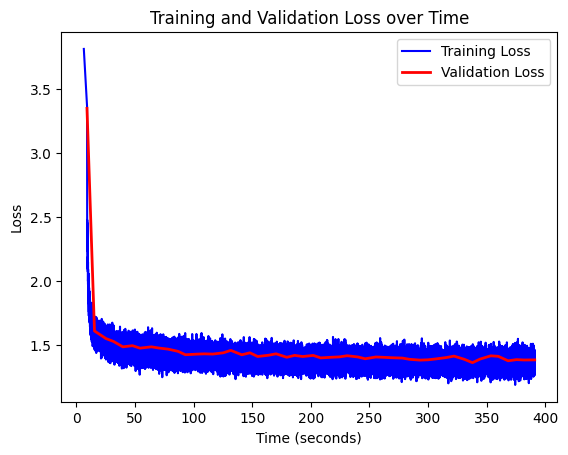

In [12]:
# Plot training and validation loss curves
plt.plot(train_time_history, train_loss_history, "-",label='Training Loss', color='blue')
plt.plot(val_time_history, val_loss_history, "-", label='Validation Loss', lw = 2, color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.show()

## Testing the model on a given prompt

In [13]:
# Test the model on a given prompt
prompt = "the meaning of life is"
encoded_prompt = fn.encode(prompt, chars_to_int)
context = encoded_prompt[None, :]

B = 1
seed = 42
generate_len = 1000
rng = jax.random.PRNGKey(seed)

output_indices = fn.generate_tokens(
    model=m1,
    params=params,
    rng=rng,
    context=context,
    length=generate_len,
    block_size=128,
    temperature=0.8,
    sample=True,
    pad_id=None,
    deterministic=True
)

output_indices = np.array(output_indices)  # Convert from JAX array to NumPy array
generated_text = fn.decode(output_indices, int_to_chars)

print("Generated ID Shape:", output_indices.shape)
print("Generated Text:")
print(prompt + generated_text)

Generated ID Shape: (1, 1000)
Generated Text:
the meaning of life isawhononevuninonenevagniscinononunon son ma genein deaninyeitbmmanabin burevitknurtidatirmonithitolera alendes rallly sa  e  ra ese silde andenga in s hto edic a cz mambsre athan ato eritaly lliesnendemo as s esest st de isponadeca owassuxiverrandev crelederelit bmr choutt londdemyichorearet adenukin tongearereeren jimirogonedemomad d a at kar tiviviad c orodaw t aranongs t ed atouxinn reliveke dge the aly  th ces ci ine anous tridema thid idis aonon dichas the fl e pinhalon ivenetumaman asgedrus pitedo astsirethalamitrgharo ator orelos tinyateya wme abe asttorerroumb sstalelatotulirbnx uratorrilereq busa ophouxlatove icange ade fear adour shiman be k t orret e mataw se sheric sor pp est fd ia ue te haslitst rorto ondoum bhithe cre adena w posten thiviv pisov asire orinandmon tasoumoulovim besas acgenenadigelon cedacateric an rgonisstitspileastsalisangutur dillon govane c tvinind tesndubmanumith ase thos titatsor erarim